<a href="https://colab.research.google.com/github/geekpradd/Reinforcement-Learning-Stock-Trader/blob/master/New_Stock_Updated1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from math import floor, ceil
import random
from tensorflow.keras.layers import Dense, Concatenate, Lambda, Activation, LSTM
from tensorflow.keras import Input
from tensorflow import convert_to_tensor as convert
import pickle
COLAB = False
if not COLAB:
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
path_base = 'models/'

In [104]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.df = df
        self.state_dimensions = 6
        self.shares_normal = params['shares_normal']
        self.train = train

        self.max_steps = len(self.df.loc[:, "Open"])
        self.action_space = spaces.Box(low = -1, high = 1, shape =  (1, 1), dtype = np.float32)
        self.observation_space = spaces.Box(low = 0, high = 1, shape = (1, self.state_dimensions), dtype = np.float32)

    def reset(self, initial_balance = 10000, shares_held = None):
        self.start_balance = initial_balance 
        if self.train:
            self.current_step = np.random.randint(0, self.max_steps)
        else:
            self.current_step = 0
        self.balance = initial_balance
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = 0
        self.current_price = self.get_price()
        self.net_worth = self.balance + (self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.done = False
        self.frame = np.zeros((1, self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'balance' : self.balance,
        }
        return self.observe()
        
    def get_price(self):
        return np.random.uniform(self.df.loc[self.current_step,"Low"], self.df.loc[self.current_step,"High"]) 
      
    def observe(self):
        self.frame[0, 0:4] = np.array([self.df.loc[self.current_step,'Open'],self.df.loc[self.current_step,'High'],self.df.loc[self.current_step,'Low'],self.df.loc[self.current_step,'Close']])/self.balance
        self.frame[0, 4] = self.shares_held/self.shares_normal
        self.frame[0, 5] = self.balance/self.start_balance
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'balance' : self.balance
        }
        return self.frame, self.info
    
    def update_worth(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def update_balance(self, action):
        self.balance -= action*self.current_price

    def update_shares(self, action):
        self.shares_held += action

    def take_action(self, action):
        self.current_price = self.get_price()
        max_buyable = self.balance/self.current_price
        max_sellable = self.shares_held
        if action >= 0:
            action *= max_buyable
            action = floor(action)
        else:
            action *= max_sellable
            action = ceil(action)
            
        if self.shares_held == 0 and action < 0:
            reward = -self.balance/2 if self.train else 0
            print ("Invallid sell action")
        else:
            self.update_balance(action)
            self.update_shares(action)
            reward = self.balance + (self.shares_held * self.current_price) - self.net_worth
            self.update_worth(reward)
        return reward
            
    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros((1, self.state_dimensions)), 0, self.done, self.info

        reward = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.05
        if self.done:
            print('snap')
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(location, train=True):
    df = pd.read_csv(location).sort_values('Date')
    params = {
        'num_stocks' : 1,
        'min_brokerage' : 30.0,
        'shares_normal' : 10000,
        'brokerage_rate' : 0.001,
    }
    return StockEnv(df, params, train)

In [105]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

from collections import deque
class ReplayDeque:
    def __init__(self, capacity, element_dimensions):
        self.deque = deque()
        self.capacity = capacity
        self.dim = element_dimensions
        for _ in range(self.capacity):
            self.deque.append(np.zeros((element_dimensions, )))
            
    def add(self, obj):
        copied = np.copy(obj)
        self.deque.append(np.squeeze(copied))
        self.deque.popleft()
        
    def get_last(self, duration):
        entries = list(self.deque)[-duration:]
        shape = list(entries[0].shape)
        shape[:0] = [1, len(entries)]
        res = np.concatenate(entries).reshape(shape)
        return res
    def clear(self):
        self.__init__(self.capacity, self.dim)
        
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return np.squeeze(x)

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [106]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.state_dimensions = params["state_dimensions"]
        self.replay_length = params["replay_length"]
        self.action_dimensions = params["action_dimensions"]
        self.replay_length = params["replay_length"]
        self.cap = params['cap']
        self.actor = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=(self.state_dimensions*self.replay_length, ))
        x = Dense(60, activation = 'relu')(inputs)
#         self.lstm_layer = LSTM(16)
#         x = self.lstm_layer(x)
        x = Dense(16, activation='relu')(x)
        x = Dense(1, activation='tanh')(x)
        model = keras.Model(inputs = inputs, outputs = x)
        # model.summary()
        return model
    
    def get_action(self, state):
#         print ("mm state")
#         print (state)
        return self.actor(convert(state))

    def save(self):
        self.actor.save(path_base + 'actor.h5')
    
    def load(self):
        self.actor = keras.models.load_model(path_base + 'actor.h5')
        print('Successfully Loaded')

class Critic:
    def __init__(self, params):
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.replay_length = params["replay_length"]
        self.optimizer = params["critic_optimizer"]
        self.tau = params['tau']
        self.critic_online = self.build_model()
        self.critic_target = self.build_model()
        self.critic_online.set_weights(self.critic_target.get_weights())

    def build_model(self):
        input_a = Input(shape = (self.state_dimensions*self.replay_length, ))
        input_b = Input(shape = (self.action_dimensions, ))
        input = Concatenate(axis = -1)([input_a, input_b])
        x = Dense(60, activation = 'relu')(input)
        x = Dense(16, activation = 'relu')(x)
        output = Dense(1)(x)
        model = keras.Model(inputs=[input_a, input_b], outputs = output)
        model.compile(loss='mse', optimizer = keras.optimizers.Adam(learning_rate = 0.001))
        # model.summary()
        return model

    def save(self):
        self.critic_online.save(path_base + 'critic_online.h5')
        self.critic_target.save(path_base + 'critic_target.h5')

    def load(self):
        self.critic_online = keras.models.load_model(path_base + 'critic_online.h5')
        self.critic_target = keras.models.load_model(path_base + 'critic_target.h5')

    def get_qvalues(self, state_array, action_array, online=True):
        if online:
            return self.critic_online([convert(state_array), convert(action_array)])
        else:
            return self.critic_target([convert(state_array), convert(action_array)])

    def call(self, state_tensor, action_tensor):
        return self.critic_online([state_tensor, action_tensor])
    
    def merge(self):
        self.critic_target.set_weights(self.tau*np.array(self.critic_online.get_weights())
                                                                    + (1-self.tau)*np.array(self.critic_target.get_weights()))

In [119]:
class Agent:
    def __init__(self, params, train = True, resume = True):
        self.train = train
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayMemory(params["buffer_size"])
        self.replay_length = params["replay_length"]
        self.state_dimensions = params["state_dimensions"]
        self.past_states = ReplayDeque(self.replay_length, self.state_dimensions)
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.cap = params['cap']
        self.num_steps = 0
        self.noise_func = OrnsteinUhlenbeckActionNoise(mu=np.zeros(self.action_dimensions))
        if resume:
            self.load()
        
    def clear_memory(self):
        self.past_states.clear()
    def agent_start(self, observation):
        self.past_states.add(observation)
        state = np.reshape(self.past_states.get_last(self.replay_length), (1, -1))
        action = np.squeeze(self.actor.get_action(state).numpy())
#         print ("start")
#         print (observation)
        print (state.shape)
        print (action)
        if self.train:
            action = self.clip_action(action + self.noise_func())
        else:
            action = self.clip_action(action)
        
        self.prev_state = state
        self.prev_action = action
        return action

    def clip_action(self, action):
        if action > 1:
            action = 1
        if action < -1:
            action = -1
        return action

    def agent_step(self, reward, observation):    
        self.past_states.add(observation)
#         print ("step")
#         print (observation)
        state = np.reshape(self.past_states.get_last(self.replay_length), (1, -1))
        action = np.squeeze(self.actor.get_action(state).numpy())
        if self.train:
            replay = (self.prev_state, self.prev_action, reward, state)
            self.buffer.append(replay)
#         print ("ok?")
        if self.train:
            action = self.clip_action(action + self.noise_func())
            self.run()
        else:
            action = self.clip_action(action)
        self.prev_action = action
        self.prev_state = state
        return self.prev_action 
    
    def reset(self):
        self.actor.reset()
    def save(self):
        self.actor.save()
        self.critic.save()
        data = (self.buffer, self.num_steps, self.noise_func)
        with open (path_base + 'auxiliary.pkl', 'wb') as f:
            pickle.dump(data, f)

    def load(self):
        self.actor.load()
        self.critic.load()
        with open (path_base + 'auxiliary.pkl', 'rb') as f:
            data = pickle.load(f)
        self.buffer, self.num_steps, self.noise_func = data
    
    def run(self):
        self.num_steps += 1
        size = min(self.batch_size, self.buffer.size)
        batch = self.buffer.sample(size)

        prev_states = np.array([x[0] for x in batch]).reshape((-1, self.state_dimensions*self.replay_length))
        prev_actions = np.array([x[1] for x in batch]).reshape((-1, self.action_dimensions))
        rewards = np.array([x[2] for x in batch]).reshape((-1, 1))
        states = np.array([x[3] for x in batch]).reshape((-1, self.state_dimensions*self.replay_length))
        actions = self.actor.get_action(states)
        q_values = self.critic.get_qvalues(states, actions, False)
        q_values += self.discount*rewards
        self.critic.critic_online.fit([states, actions], q_values, epochs = 1, verbose=0)

        prev_state_tensor = convert(prev_states)
        prev_action_tensor = convert(prev_actions)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(prev_action_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.actor(prev_state_tensor)
        gradient = -tape.gradient(value, prev_action_tensor)
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = tape.gradient(action, self.actor.actor.trainable_weights, gradient)
        gradient_actor = list(np.array(gradient_actor)/size)

        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))
        self.critic.merge()

        if self.num_steps % self.save_frequency == 0:
            self.save()

In [162]:
AGENT_PARAMS = {
	"output_range": 1,
	"state_dimensions": 6,
    "replay_length": 10,
	"action_dimensions": 1,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"batch_size": 64,
	"buffer_size":100000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 5000,
	'cap' : 0.9,
}

In [170]:
files = 'data/PCG.csv'
env = create_stock_env(files)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS, train = True,resume = True)

In [171]:
def train(agent, env, epochs, profits, balances, shares, actions, steps_per_epoch):
    
    for epoch in range(0, epochs):

        cumm_profit = 0
        observation, info = env.reset()
        shares[epoch, 0] = info['shares_held']
        balances[epoch, 0] = info['balance']
        action = agent.agent_start(observation)
        actions[epoch, 0] = action

        for i in tqdm_notebook(range(steps_per_epoch)):
#             print (agent.past_states.deque)
            observation, reward, done, info = env.step(action)
#             print ("Observation")
#             print (observation)
#             print ("ok")
            shares[epoch, i+1] = info['shares_held']
            balances[epoch, i+1] = info['balance']
            cumm_profit += reward
            profits[epoch, i] = cumm_profit
            if done:
                print("the end")
                break
            action = agent.agent_step(reward, observation)
            actions[epoch, i+1] = action

        agent.clear_memory()
        print('Completed epoch' + str(epoch))

        if epoch % 10 == 0:
            data = epoch, profits, shares, balances, actions
            with open(path_base + 'graph.pkl', 'wb') as f:
                pickle.dump(data, f)

In [190]:
# with open(path_base + 'graph.pkl', 'rb') as f:
#     data = pickle.load(f)
epochs = 50
steps_per_epoch = 2000
profits = np.zeros((epochs, steps_per_epoch+1))
balances = np.zeros((epochs, steps_per_epoch+1))
shares = np.zeros((epochs, steps_per_epoch+1))
actions = np.zeros((epochs, steps_per_epoch+1))
train(agent, env, epochs, profits, balances, shares, actions, steps_per_epoch)

(1, 60)
1.0



Completed epoch0
(1, 60)
-0.9897467



Completed epoch1
(1, 60)
-0.98241115


the end
Completed epoch2
(1, 60)
-0.98167396



Completed epoch3
(1, 60)
-0.98498833


the end
Completed epoch4
(1, 60)
-0.98410827



Completed epoch5
(1, 60)
-0.98198634



Completed epoch6
(1, 60)
-0.98873246


the end
Completed epoch7
(1, 60)
-0.98923516



Completed epoch8
(1, 60)
-0.98827356



Completed epoch9
(1, 60)
-0.9912215



Completed epoch10
(1, 60)
-0.9935873



Completed epoch11
(1, 60)
-0.99407846



Completed epoch12
(1, 60)
-0.99488264



Completed epoch13
(1, 60)
-0.99375755


the end
Completed epoch14
(1, 60)
-0.99310356



Completed epoch15
(1, 60)
-0.9917106


the end
Completed epoch16
(1, 60)
-0.99391264



Completed epoch17
(1, 60)
-0.9935841



Completed epoch18
(1, 60)
-0.99352


the end
Completed epoch19
(1, 60)
-0.9929394



Completed epoch20
(1, 60)
-0.99288917


the end
Completed epoch21
(1, 60)
-0.99280983



Completed epoch22
(1, 60)
-0.9877352



Completed epoch23
(1, 60)
-0.98988354



Completed epoch24
(1, 60)
-0.98440653



Completed epoch25
(1, 60)
-0.98706526


the end
Completed epoch26
(1, 60)
-0.9908688



Completed epoch27
(1, 60)
-0.98765004


the end
Completed epoch28
(1, 60)
-0.99027985



Completed epoch29
(1, 60)
-0.9805347



Completed epoch30
(1, 60)
-0.9650654



Completed epoch31
(1, 60)
-0.93449783



Completed epoch32
(1, 60)
0.05951277



Completed epoch33
(1, 60)
0.81469303



Completed epoch34
(1, 60)
0.86522084



Completed epoch35
(1, 60)
0.7078951



Completed epoch36
(1, 60)
0.84522057



Completed epoch37
(1, 60)
0.9498412


the end
Completed epoch38
(1, 60)
0.9512007




Completed epoch39
(1, 60)
0.97813195


the end
Completed epoch40
(1, 60)
0.96097666



Completed epoch41
(1, 60)
0.99286956



Completed epoch42
(1, 60)
0.99610406



Completed epoch43
(1, 60)
0.9995394


the end
Completed epoch44
(1, 60)
0.99977815


the end
Completed epoch45
(1, 60)
0.99991626



Completed epoch46
(1, 60)
0.99997485



Completed epoch47
(1, 60)
0.99999696



Completed epoch48
(1, 60)
0.99999815



Completed epoch49


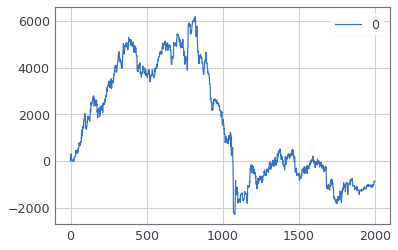

In [193]:
# for _ in range(0,10):
#     plt.plot(profits[_])
plt.plot(profits[49][:-1])
plt.legend(list(range(10)))
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

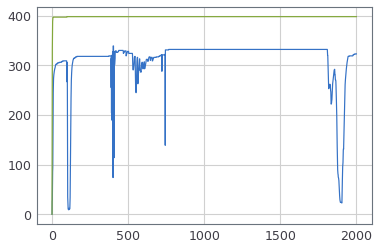

In [127]:
for _ in range(10):
    plt.plot(shares[_])

plt.legend(list(range(10)))
plt.show()

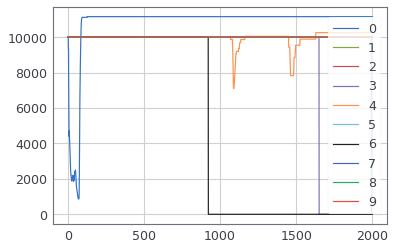

In [87]:
for _ in range(10):
    plt.plot(balances[_])

plt.legend(list(range(10)))
plt.show()

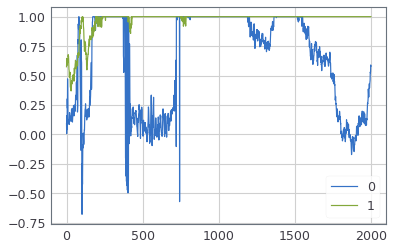

In [128]:
for _ in range(0, 2):
    plt.plot(actions[_])

plt.legend(list(range(10)))
plt.show()

In [137]:
print(env.net_worth)
print(env.balance)
print(env.shares_held)

16032.571214787878
1.0105026416597127
398


In [187]:
def test(values):
    num = len(values)
    env = create_stock_env(files, train = False)
    agent = Agent(AGENT_PARAMS, train = False, resume = True)
    print(agent.num_steps)
    max_steps = env.max_steps
    profitst = np.zeros((num, max_steps+1))
    balancest = np.zeros((num, max_steps + 1))
    sharest = np.zeros((num, max_steps+1))
    actionst = np.zeros((num, max_steps+1))
    worthst = np.zeros((num, max_steps+1))
    for count, val in enumerate(values):
        profit = 0
        profitst[count][0] = profit
        observation, info = env.reset(initial_balance = val)
        balancest[count][0] = info['balance']
        print(info['balance'])
        sharest[count][0] = info['shares_held']
        worthst[count][0] = info['net_worth']
        print(info['shares_held'])
        action = agent.agent_start(observation)
        actionst[count][0] = action

        for i in tqdm_notebook(range(max_steps)):
            observation, reward, done, info = env.step(action)
            profit += reward
            profitst[count][i+1] = profit
            balancest[count][i+1] = info['balance']
            sharest[count][i+1] = info['shares_held']
            worthst[count][i+1] = info['net_worth']
            if done:
                print ("ober")
                break
            action = agent.agent_step(reward, observation)
            actionst[count][i+1] = action
              
        print('Completed' + str(count) + 'values')

    print(env.net_worth)
    print(env.balance)
    print(env.shares_held)
    return profitst, balancest, sharest, actionst, worthst


In [198]:
values = [10000]
profitst, balancest, sharest, actionst, worthst = test(values)

Successfully Loaded
125000
10000
0
(1, 60)
0.99999607


ober
Completed0values
3170.8377623112447
0.2994553294755775
302


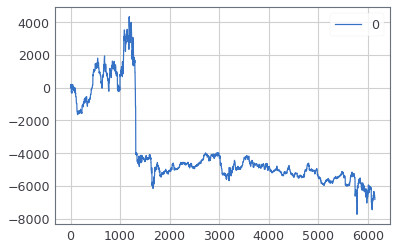

In [199]:
for i in range(1):
    plt.plot(profitst[i])

plt.legend(list(range(5)))
plt.show()

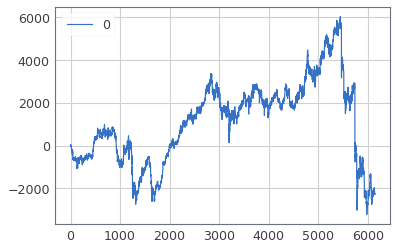

In [161]:
for i in range(1):
    plt.plot(profitst[i])

plt.legend(list(range(5)))
plt.show()

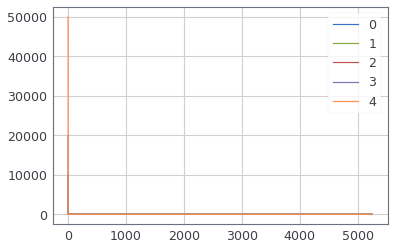

In [57]:
for i in range(5):
    plt.plot(balancest[i])
plt.legend(list(range(5)))
plt.show()

In [32]:
st = ReplayDeque(10, 5)

In [33]:
st.deque

deque([array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.])])

In [34]:
st.add(np.array([1, 2, 3, 4, 5]))

In [35]:
st.deque

deque([array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([1, 2, 3, 4, 5])])

In [36]:
st.add(np.array([10, 2, 3, 4, 5]))

In [38]:
st.deque

deque([array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0.]),
       array([1, 2, 3, 4, 5]),
       array([10,  2,  3,  4,  5])])